# Interpreting your Machine Learning Model : Why and How

[ _A tutorial made for the_ __[MLcourse.ai course](https://mlcourse.ai/)__. ]


***

>_"models are opinions embedded in mathematics" - Cathy O'Neil_

>_"Science without conscience is but the ruin of the Soul" - Rabelais (who first quoted the word "automaton" in french during the 16th century)_



<center><img src="_Images/MLI_fun.png" alt="machine-learning-interpretability-fun" title="MLI Funny" height="228" width="405" /></center>

Machine Learning Interpretability of is a hot and crucial subject : machine learning algorithms are everywhere, becoming more and more ubiquitous, complex and efficient, sometimes treated like black-boxes. They have already, and will have, more and more impact in the futur on society and our everyday's life. As (futur) Data Scientist / Machine Learning Engineers, even if we clearly don't need interpretability all the time, i think we have a social and professional ethical duty trying to design models as **fair, accountable and transparent** as possible. For exemple the recent european GDRP (General Data Protection Regulation) resolution attest for a citizen "right to explanation" of algorithmic decisions that "significantly" affect any individual. Further more, interpreting our machine learning processes could give us valuable insights for :

- reliability
- debugging
- informing feature engineering
- model comparisons
- driving future data collection
- informing human decision-making
- and generally for better communication and building trust.

The intend of this tutorial is twofold :
- to give a basic introduction to the subject, looking at different strategies for tackling the potential "black-box" problem in a **model-agnostic** fashion. 
- to have a practical grasp on some of the main frameworks actually available for machine learning interpretability like ELI5, LIME, SKATER, or SHAP. 

We will be exploring differents classical interpretation techniques like :
1. Feature Importances
2. Partial Dependence Plots
3. Model Prediction Explanations with Local Interpretation (LIME)
4. Building Interpretable Models with Surrogate Tree-based Models (SKATER)
5. Model Prediction Explanation with SHAP values
6. Dependence and Interaction Plots (SHAP)

We will work on a real-world dataset about Red Wine Quality (after all ethics can, and should be, also convivial ;)) and with an XGBoost model, which is an optimized distributed gradient boosting library providing a parallel tree boosting algorithm. The learning task will be a classical supervised  classification with binarized classes.


`Christophe Rigon > datacog@free.fr`


# Load dependencies

In [1]:
### Elementary my Dear Watson...
import pandas as pd
import numpy as np

### Graphic libraries
import matplotlib.pyplot as plt
import seaborn as sns 

### Some Scikit-learn utils
from sklearn.model_selection import train_test_split

### Metrics
from sklearn import metrics
from sklearn.metrics import accuracy_score, roc_curve, auc

### Models
from xgboost import XGBClassifier, plot_importance

### Interpretability libraries
import shap
# pip install eli5
import eli5
from eli5.sklearn import PermutationImportance

### Some cosmetics add-ons
import warnings
warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')
%matplotlib inline


# Load the Red Wine Quality Dataset

The Red Wine Quality dataset can be downloaded __[on this Kaggle page](https://www.kaggle.com/uciml/red-wine-quality-cortez-et-al-2009)__ or via the __[UCI Machine Learning repository](https://archive.ics.uci.edu/ml/datasets/wine+quality)__.

"This datasets is related to red variants of the Portuguese "Vinho Verde" wine. For more details, consult the reference __[Cortez et al., 2009](http://dx.doi.org/10.1016/j.dss.2009.05.016)__. Due to privacy and logistic issues, only physicochemical (inputs) and sensory (the output) variables are available (e.g. there is no data about grape types, wine brand, wine selling price, etc.)."

In [2]:
# loading the csv dataset in a dataframe
df_raw = pd.read_csv('data/winequality-red.csv')
df_raw.shape

(1599, 12)

I have choose a small and cleaned dataset (1599 rows x 11+1 variables) for quick and easy processing.

## Data Description

**Input variables (based on physicochemical tests)**:
1. _fixed acidity_ : most acids involved with wine or fixed or nonvolatile (do not evaporate readily).
2. _volatile acidity_ : the amount of acetic acid in wine, which at too high of levels can lead to an unpleasant, vinegar taste.
3. _citric acid_ : found in small quantities, citric acid can add 'freshness' and flavor to wines.
4. _residual suga_ : the amount of sugar remaining after fermentation stops, it's rare to find wines with less than 1 gram/liter and wines with greater than 45 grams/liter are considered sweet.
5. _chlorides_ : the amount of salt in the wine.
6. _free sulfur dioxide_ : the free form of SO2 exists in equilibrium between molecular SO2 (as a dissolved gas) and bisulfite ion; it prevents microbial growth and the oxidation of wine.
7. _total sulfur dioxide_ : amount of free and bound forms of S02; in low concentrations, SO2 is mostly undetectable in wine, but at free SO2 concentrations over 50 ppm, SO2 becomes evident in the nose and taste of wine.
8. _density_ : the density of water is close to that of water depending on the percent alcohol and sugar content.
9. _pH_ : describes how acidic or basic a wine is on a scale from 0 (very acidic) to 14 (very basic); most wines are between 3-4 on the pH scale.
10. _sulphates_ : a wine additive which can contribute to sulfur dioxide gas (S02) levels, wich acts as an antimicrobial and antioxidant.
11. _alcohol_ : the percent alcohol content of the wine.

**Output variable (based on sensory data)**:
12. _quality_ : score between 0 and 10 given by human wine tasters.
<br><br><br>

In [3]:
# Let's visually check the first lines of our wine collection
df_raw.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [4]:
# types of data
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
fixed acidity           1599 non-null float64
volatile acidity        1599 non-null float64
citric acid             1599 non-null float64
residual sugar          1599 non-null float64
chlorides               1599 non-null float64
free sulfur dioxide     1599 non-null float64
total sulfur dioxide    1599 non-null float64
density                 1599 non-null float64
pH                      1599 non-null float64
sulphates               1599 non-null float64
alcohol                 1599 non-null float64
quality                 1599 non-null int64
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [5]:
# Synthetic descriptive statistics
df_raw.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


In [6]:
# make a copy of the original dataframe before processing further
wines = df_raw.copy()

# Quick EDA and Visualization

Exploration data analysis and visualization are the **first tools** for interpreting and getting latent insights from data. They help us in identifying key features and meaningful representations, even with large datasets with for exemple dimensionality reduction techniques (PCA, t-SNE, etc). 

So let's now make a quick exploration data analysis to see how the data are distributed and correlated. 

In [7]:
# Extracting our target variable 
# and creating a feature list of dependant variables
target = 'quality'
features_list = list(wines.columns)
features_list.remove(target)

## Univariate Analysis (features and target 'quality')

### Features

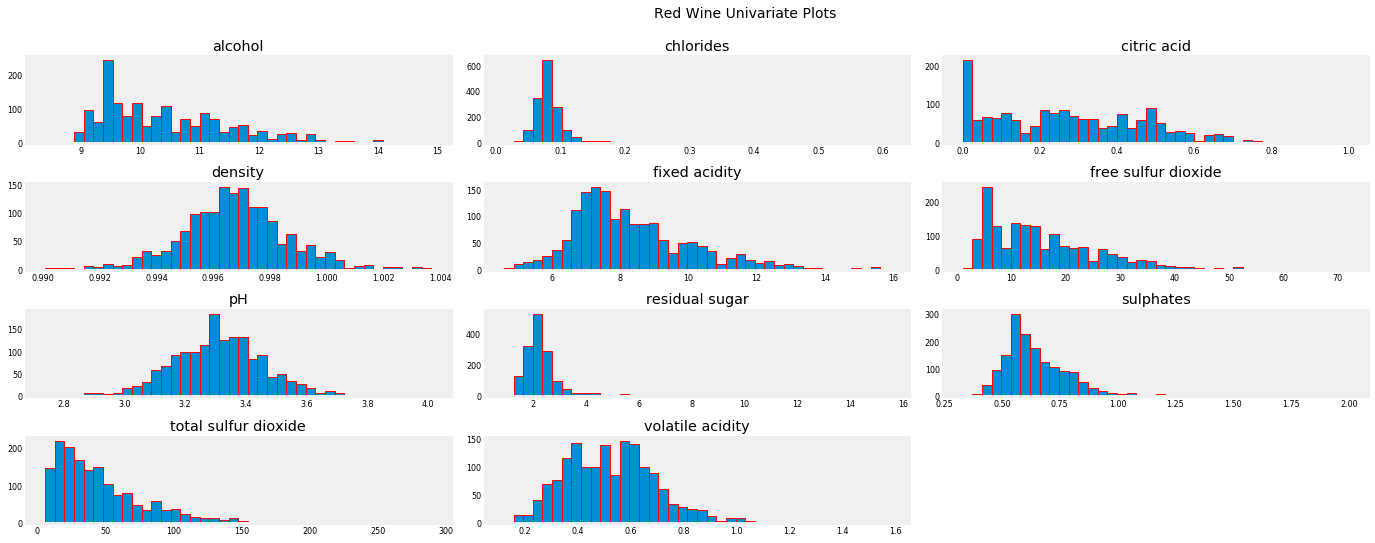

In [8]:
wines[features_list].hist(bins=40, edgecolor='red', linewidth=1.0,
              xlabelsize=8, ylabelsize=8, grid=False, figsize=(16,6))    
plt.tight_layout(rect=(0, 0, 1.2, 1.2))   
plt.suptitle('Red Wine Univariate Plots', x=0.65, y=1.25, fontsize=14);  

> We can note that somme features, like 'sulfur dioxide' or 'sulphates' for exemple, has a right skewed distribution and should probably be engineered into their log forms.

### Target

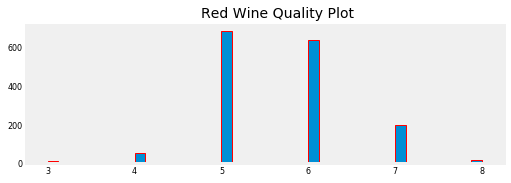

In [9]:
wines[target].hist(bins=40, edgecolor='red', linewidth=1.0,
              xlabelsize=8, ylabelsize=8, grid=False, figsize=(6,2))    
plt.tight_layout(rect=(0, 0, 1.2, 1.2))   
plt.suptitle('Red Wine Quality Plot', x=0.65, y=1.25, fontsize=14);  

## Multivariate Analysis

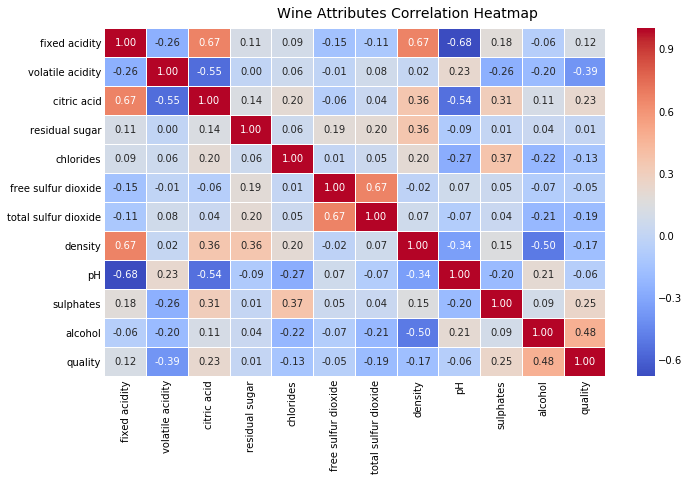

In [10]:
# for visualizing correlations
f, ax = plt.subplots(figsize=(10, 6))
corr = wines.corr()
hm = sns.heatmap(round(corr,2), annot=True, ax=ax, cmap="coolwarm",fmt='.2f',
            linewidths=.05)
f.subplots_adjust(top=0.93)
t= f.suptitle('Wine Attributes Correlation Heatmap', fontsize=14)

Well, surprisingly the alcool level seems to play an important role in this notation. Seriously ?! :)

# Building Train and Test Datasets

Now for sake of simplicity let's transform our target data to a binary classification problem and build our train and test datasets on a classical 70/30 ratio.

In [11]:
# create our separate target vector 
y = wines.pop('quality')

# mapping the target to a binary class
y = y.apply(lambda x: 0 if x <= 5 else 1)

# quickly check that we have a balanced partition
y.sum() / len(y)

0.5347091932457786

In [12]:
X_train, X_test, y_train, y_test = train_test_split(wines, y, test_size=0.3, random_state=33)
X_train.shape, X_test.shape

((1119, 11), (480, 11))

# Training our classification model

We will now instanciate and train an out-of-the-box XGBoost classification model on our train data

In [13]:
%%time

# ML in two lines ;)
xgb = XGBClassifier(objective='binary:logistic', random_state=33, n_jobs=-1)
xgb.fit(X_train, y_train)

Wall time: 962 ms


# Model Performance Evaluation

Let's test our model and evaluate how our model has performed with its predictions on the test data. We won't perform here any cross-validation on our model, as one should probably do in a real context.

# Making predictions on the test data and performance evaluation

## Prediction

In [14]:
# make predictions for test data
xgb_predictions = xgb.predict(X_test)

## Evaluation of performance

### Accuracy, Precision/Recall, F1 Metrics & Confusion matrix

In [15]:
# Let's design a simple classification evaluative function
def evaluation_scores(test, prediction):
    print('Accuracy:', np.round(metrics.accuracy_score(test, prediction), 4)) 
    print('-'*60)
    print('classification report:\n\n', metrics.classification_report(y_true=test, y_pred=prediction)) 
    
    classes = [0, 1]
    total_classes = len(classes)
    level_labels = [total_classes*[0], list(range(total_classes))]

    cm = metrics.confusion_matrix(y_true=test, y_pred=prediction, labels=classes)
    cm_frame = pd.DataFrame(data=cm, columns=pd.MultiIndex(levels=[['Predicted:'], classes], labels=level_labels), 
                            index=pd.MultiIndex(levels=[['Actual:'], classes], labels=level_labels))
    
    print('-'*60)
    print('Confusion matrix:\n')
    print(cm_frame) 

In [16]:
# evaluate predictions
evaluation_scores(y_test, xgb_predictions)

Accuracy: 0.7521
------------------------------------------------------------
classification report:

               precision    recall  f1-score   support

           0       0.73      0.74      0.73       221
           1       0.78      0.76      0.77       259

   micro avg       0.75      0.75      0.75       480
   macro avg       0.75      0.75      0.75       480
weighted avg       0.75      0.75      0.75       480

------------------------------------------------------------
Confusion matrix:

          Predicted:     
                   0    1
Actual: 0        164   57
        1         62  197


### AUC / ROC Curve

AUC / ROC Curve are probably better evaluations for this classification task :

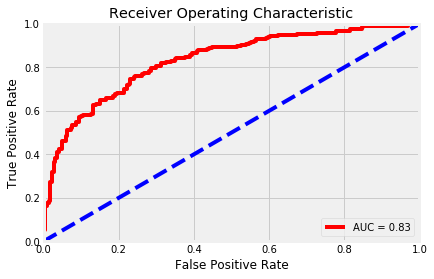

In [17]:
# calculate the FPR and TPR for all thresholds of the classification
probs = xgb.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'r', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'b--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Well, not too bad without any tuning or feature engineering.

<br><br>
>>> Now let's dive into the **interpretation of our model**.

# The trade-off Accuracy / Interpretability

In general machine learning design there is a well known trade-off between the bias and the variance of a model, or between precision and recall in classification algorithms.

Similarly, in ML Interpretability, there is the **Accuracy / Interpretability trade-off** rule of thumb which states that generally, the more accurate is a model (or a model of models, like ensemble's bagging and boosting), the more complex it is and so the more difficult it is to interpret it's outputs.

<img src="../_Images/Acuracy_interpretability.png" alt="accuracy-interpretability-trade-off" title="The Accuracy vs Interpretability trade-off" />

More, accuracy cannot stand alone for buiding trust on our models because of possible overfitting of the model, correlations of the features and noise in the data.

So we need more sophisticated metrics and analytics than just plain accuracy of the results.

# Default Model Interpretation Methods

Non-parametrics models like tree-based models as XGBoost are more difficult to interprete because their total number of parameters is not fixed and will grow with the volume of data used for the training. Parametrics models (ex: logistic regression) offers a contrario a first level of interpretation by the way of their coefficients. Fortunately many non-parametric algorithms, like XGBoost, give an access to interpretation methods like feature importance for helping us to understand the inner evaluation of the model for making his predictions.

## Feature importances

To interpret a model, we basically need to know :

- which features are the most important in the model
- the effect of each feature on a particular prediction
- the effects of each feature over a large number of predictions
    
Native global feature importance calcuations that come with XGBoostare based on the following parameters :

- Feature Weights: based on the number of times a feature appears in a tree across the ensemble of trees
- Coverage: the average coverage (number of samples affected) of splits which use the feature
- Gain: the average gain of splits which use the feature

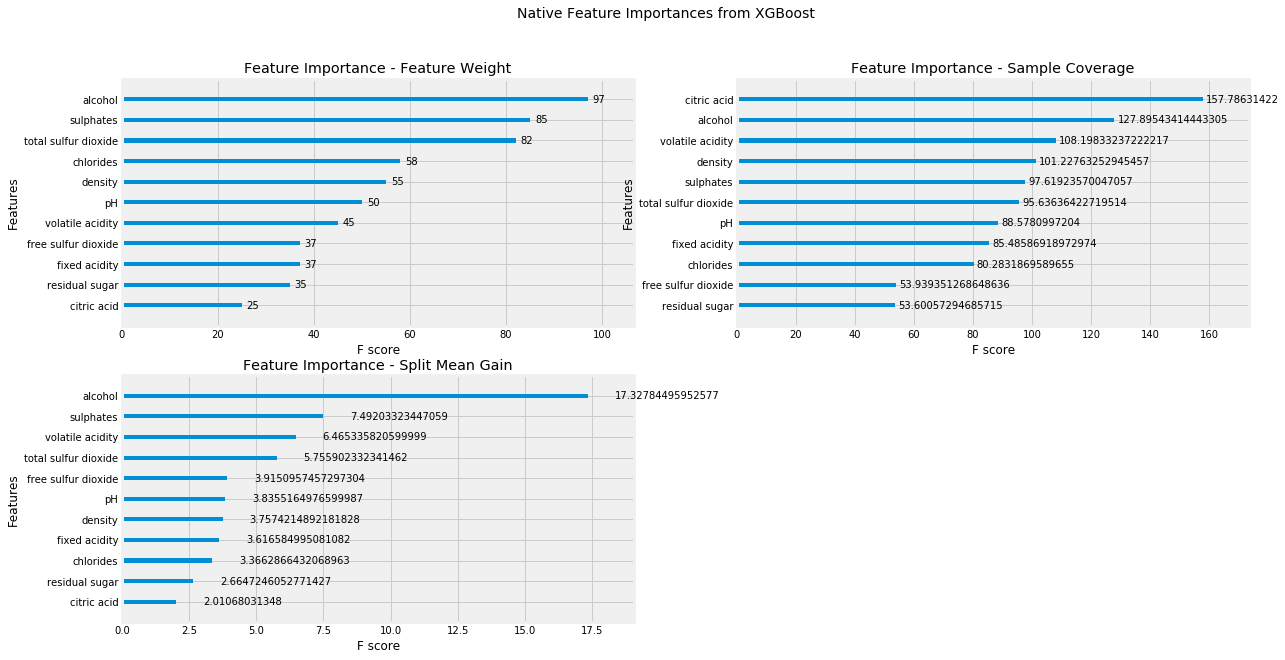

In [18]:
# ploting XGBoost default feature importances
fig = plt.figure(figsize = (18, 10))
title = fig.suptitle("Native Feature Importances from XGBoost", fontsize=14)

ax1 = fig.add_subplot(2, 2, 1)
plot_importance(xgb, importance_type='weight', ax=ax1)
ax1.set_title("Feature Importance - Feature Weight");

ax2 = fig.add_subplot(2, 2, 2)
plot_importance(xgb, importance_type='cover', ax=ax2)
ax2.set_title("Feature Importance - Sample Coverage");

ax3 = fig.add_subplot(2, 2, 3)
plot_importance(xgb, importance_type='gain', ax=ax3)
ax3.set_title("Feature Importance - Split Mean Gain");

As you can see, features are ordered in differents ways by these different criters. We need a more **consistent** way of doing so. As we will see later, Shapley values offer us such a consistent way.

#  ELI5 Model Interpretation

According to their documentation, [ELI5](https://github.com/TeamHG-Memex/eli5) ("Explain Like I'm 5") is a Python library which helps to debug machine learning classifiers and regressors and explain their predictions in an easy to understand an intuitive way. ELI5 is a good starting point and support tree-based and parametric/linear models but also text processing and HashingVectorizer utilities from scikit-learn but it doesn't support true model-agnostic interpretations.

## Feature Importances

With XGBoost, ELI5 just use the same native feature importances computation methods (with the default "gain" parameter) which we have just seen earlier and  give us an easy and ergonomic way of displaying it with the `eli5.show_weights` method.

In [19]:
eli5.show_weights(xgb.get_booster())

Weight,Feature
0.2878,alcohol
0.1244,sulphates
0.1074,volatile acidity
0.0956,total sulfur dioxide
0.0650,free sulfur dioxide
0.0637,pH
0.0624,density
0.0601,fixed acidity
0.0559,chlorides
0.0443,residual sugar


## Explaining Model Prediction Decisions with ELI5

To make random forest predictions more interpretable, every prediction of the model can be trivially presented as a sum of feature contributions (plus the bias), showing how the features lead to a particular prediction. ELI5 does it by showing weights for each feature depicting how influential it might have been in contributing to the final prediction decision across all trees. This is a good step in direction of model-agnostic interpretation but not entirely model-agnostic like, we will see it later, for LIME.

Let's examine individual data-point predictions, one for each class ("0" : quality wine noted <= 5, and "1" with note > 5) with the `eli5.show_prediction` method.

### Predicting when a wine note will be <= 5

In [20]:
wine_nb = 0
print('Reference:', y_test.iloc[wine_nb])
print('Predicted:', xgb_predictions[wine_nb])
eli5.show_prediction(xgb.get_booster(), X_test.iloc[wine_nb], 
                     feature_names=list(wines.columns), show_feature_values=True)

Reference: 0
Predicted: 0


In this individual prediction, the top 3 influencal features seems to be the pH, density, and residual sugar.

### Predicting when a wine note will be > 5

In [21]:
wine_nb = 4
print('Reference:', y_test.iloc[wine_nb])
print('Predicted:', xgb_predictions[wine_nb])
eli5.show_prediction(xgb.get_booster(), X_test.iloc[wine_nb], 
                     feature_names=list(wines.columns), show_feature_values=True)

Reference: 1
Predicted: 1


In this one, sulfate, citric acid, and chlorides seems to be prevalent.

> Note how a feature like 'sulphates' play an opposite influential role in explaining model prediction between the two classes and acts like a flag in these two particular examples .

### Features Permutation Importances

eli5 provides a way to compute feature importances for any black-box estimator by measuring how score decreases when a feature is not available; the method is also known as “**permutation importance**” or “Mean Decrease Accuracy (MDA). This is more reliable but this technique is computationaly slow with a big number of features.

> As in our case, If you don’t have a separate held-out dataset, you can fit PermutationImportance on the same data as used for training; this still allows to inspect the model, but doesn’t show which features are important for **generalization**.

In [22]:
%%time

# we need to retrain a new model with arrays
# as eli5 has a bug with Dataframes and XGBoost
# cf. https://github.com/TeamHG-Memex/eli5/pull/261
xgb_perm = XGBClassifier(random_state=33, n_jobs=-1)
xgb_perm.fit(X_train.values, y_train)

Wall time: 128 ms


In [23]:
feat_permut = PermutationImportance(xgb_perm, random_state=33).fit(X_train, y_train)
eli5.show_weights(feat_permut, feature_names = features_list)

Weight,Feature
0.1659 ± 0.0168,alcohol
0.0811 ± 0.0166,sulphates
0.0533 ± 0.0088,total sulfur dioxide
0.0343 ± 0.0087,chlorides
0.0313 ± 0.0082,volatile acidity
0.0216 ± 0.0036,free sulfur dioxide
0.0181 ± 0.0041,density
0.0173 ± 0.0077,pH
0.0127 ± 0.0057,citric acid
0.0091 ± 0.0103,fixed acidity


> You can compare this result with the basic feature classification (ie without permutation). What are the differences ? What can you infer about the reliability of these features ?

***

#  SKATER Model Interpretation

Skater is a unified framework to enable Model Interpretation for all forms of models to help one build an Interpretable machine learning system often needed for real world use-cases using a model-agnostic approach. It is an open source python library designed to demystify the learned structures of a black box model both globally (inference on the basis of a complete data set) and locally (inference about an individual prediction).

![](https://d3ansictanv2wj.cloudfront.net/Figure5-452aaf48771d7e201175954c1de6eed1.png)

Skater originally started off as a fork of LIME but then broke out as an independent framework of it's own with a wide variety of feature and capabilities for model-agnostic interpretation for any black-box models. The project was started as a research idea to find ways to enable better interpretability (preferably human interpretability) to predictive "black boxes" both for researchers and practioners. 

### Install Skater

You can typically install Skater using a simple __`pip install skater`__. For detailed information on the dependencies and intallation instruction check out [installing skater](https://datascienceinc.github.io/Skater/install.html).

### 📖 Documentation

We recommend you to check out the detailed documentation of Skater

|  |  |
|---------------------------------------------------------------------------------------|----------------------------------------------|
| [Overview](https://datascienceinc.github.io/Skater/overview.html) | Introduction to the Skater library |
| [Installing](https://datascienceinc.github.io/Skater/install.html) | How to install the Skater library |
| [Tutorial](https://datascienceinc.github.io/Skater/tutorial.html) | Steps to use Skater effectively. |
| [API Reference](https://datascienceinc.github.io/Skater/api.html) | The detailed reference for Skater's API. |
| [Contributing](https://github.com/datascienceinc/Skater/blob/master/CONTRIBUTING.rst) | Guide to contributing to the Skater project. |
| [Examples](https://datascienceinc.github.io/Skater/gallery.html) | Interactive notebook examples |


### Algorithms

```
+---------+---------+-----+-----------+-----------+--------------+--------------+--------------------+------------------+
| Scope of Interpretation |            Algorithms                                                                       |
+=========+=========+=====+===========+===========+==============+==============+=======================================+
| Global Interpretation   | `Model agnostic Feature Importance <https://tinyurl.com/feature-importance>`_               |
+---------+---------+-----+-----------+-----------+--------------+--------------+--------------------+------------------+
| Global Interpretation   | `Model agnostic Partial Dependence Plots <https://tinyurl.com/partial-dependence>`_         | 
+---------+---------+-----+-----------+-----------+--------------+--------------+--------------------+------------------+
| Local Interpretation    | `Local Interpretable Model Explanation(LIME) <https://tinyurl.com/lime-explanation>`_       |
+---------+---------+-----+-----------+-----------------------------------------+--------------------+------------------+
| Local Interpretation    | DNNs      | - `Layer-wise Relevance Propagation <https://tinyurl.com/e-layerwise>`_         |
|                         |           |   (e-LRP): image                                                                |
|                         |           |                                                                                 |
|                         |           | - `Occlusion  <https://tinyurl.com/dnn-occlusion>`_ : image                     |
|                         |           |                                                                                 |
|                         |           | - `Integrated Gradient <https://tinyurl.com/integrated-gradient>`_              |
|                         |           |   image and text                                                                |
+---------+---------+-----+-----------+-----------------------------------------+--------------------+------------------+
| Global and Local        | `Scalable Bayesian Rule Lists <https://tinyurl.com/rule-list-sbr>`_                         |
| Interpretation          |                                                                                             |
|                         | `Tree Surrogates <https://tinyurl.com/treesurrogates>`_                                     |
+---------+---------+-----+-----------+-----------+--------------+--------------+--------------------+------------------+
``` 
 

### Usage and Examples
Since the project is under active development, the best way to understand usage would be to follow the examples mentioned in the [Gallery of Interactive Notebook](https://datascienceinc.github.io/Skater/gallery.html)

# Global Interpretations with Skater

A predictive model is a mapping from an input space to an output space. Interpretation algorithms are divided into those that offer statistics and metrics on regions of the domain, such as the marginal distribution of a feature, or the joint distribution of the entire training set. In an ideal world there would exist some representation that would allow a human to interpret a decision function in any number of dimensions. Given that we generally can only intuit visualizations of a few dimensions at time, global interpretation algorithms either aggregate or subset the feature space.

Currently, model-agnostic global interpretation algorithms supported by skater include partial dependence and feature importance with a very new release of tree-surrogates also. We will be covering feature importance and partial dependence plots here

## Creating an interpretation object
The general workflow within the skater package is to create an interpretation, create a model, and run interpretation algorithms. Typically, an `Interpretation` consumes a dataset, and optionally some metadata like feature names and row ids. Internally, the `Interpretation` will generate a `DataManager` to handle data requests and sampling.

- __Local Models(`InMemoryModel`):__ To create a skater model based on a local function or method, pass in the predict function to an `InMemoryModel`. A user can optionally pass data samples to the examples keyword argument. This is only used to infer output types and formats. Out of the box, skater allows models return `numpy` arrays and `pandas` dataframes.

- __Operationalized Model(`DeployedModel`):__ If your model is accessible through an API, use a `DeployedModel`, which wraps the requests library. `DeployedModels` require two functions, an input formatter and an output formatter, which speak to the requests library for posting and parsing. The input formatter takes a `pandas` DataFrame or a `numpy` ndarray, and returns an object (such as a dict) that can be converted to JSON to be posted. The output formatter takes a requests.response as an input and returns a `numpy` ndarray or `pandas` DataFrame.

We will use the following workflow:

- Build an interpretation object
- Build an in-memory model
- Perform interpretations

In [24]:
from skater.core.explanations import Interpretation
from skater.model import InMemoryModel

In [25]:
interpreter = Interpretation(training_data=X_test, training_labels=y_test, feature_names=list(data.columns))
im_model = InMemoryModel(xgc.predict_proba, examples=X_train, target_names=['$50K or less', 'More than $50K'])

NameError: name 'data' is not defined

## Feature Importances with Skater

Feature importance is generic term for the degree to which a predictive model relies on a particular feature. The skater feature importance implementation is based on an information theoretic criteria, measuring the entropy in the change of predictions, given a perturbation of a given feature. The intuition is that the more a model's decision criteria depend on a feature, the more we'll see predictions change as a function of perturbing a feature. The default method used is `prediction-variance` which is the mean absolute value of changes in predictions, given perturbations in the data.

In [ ]:
plots = interpreter.feature_importance.plot_feature_importance(im_model, ascending=False)

## Partial Dependence

Partial Dependence describes the marginal impact of a feature on model prediction, holding other features in the model constant. The derivative of partial dependence describes the impact of a feature (analogous to a feature coefficient in a regression model). This has been adapted from _T. Hastie, R. Tibshirani and J. Friedman, Elements of Statistical Learning Ed. 2, Springer_.  2009. 

The partial dependence plot (PDP or PD plot) shows the marginal effect of a feature on the predicted outcome of a previously fit model. PDPs can show if the relationship between the target and a feature is linear, monotonic or more complex. Skater can show 1-D as well as 2-D PDPs

### PDP of 'Age' affecting model prediction

Looks like the middle-aged people have a slightly higher chance of making more money as compared to younger or older people

In [ ]:
r = interpreter.partial_dependence.plot_partial_dependence(['Age'], im_model, grid_resolution=50, 
                                                           grid_range=(0,1), n_samples=23000, 
                                                           with_variance=True, figsize = (6, 4))
yl = r[0][1].set_ylim(0, 1) 

### PDP of 'Education Num' affecting model prediction

Looks like higher the education level, the better the chance of making more money. Not surprising!

In [ ]:
r = interpreter.partial_dependence.plot_partial_dependence(['Education-Num'], im_model, grid_resolution=50, 
                                                           grid_range=(0,1), n_samples=23000, 
                                                           with_variance=True, figsize = (6, 4))
yl = r[0][1].set_ylim(0, 1) 

### PDP of 'Capital Gain' affecting model prediction

Unsurprisingly higher the capital gain, the more chance of making money, there is a steep rise in around \$5K - $8K

In [ ]:
r = interpreter.partial_dependence.plot_partial_dependence(['Capital Gain'], im_model, grid_resolution=50, 
                                                           grid_range=(0,1), 
                                                           with_variance=True, 
                                                           figsize = (8, 4), n_samples=23000,
                                                           n_jobs=-1)
yl = r[0][1].set_ylim(0, 1) 
s, e = r[0][1].get_xlim()
xl = r[0][1].set_xticks(np.arange(s, e, 10000))

### PDP of 'Relationship' affecting model prediction

Remember that relationship is coded as a categorical variable with numeric representations. Let's first look at how it is represened.

In [ ]:
pd.concat([data_disp[['Relationship']], data[['Relationship']]], axis=1).drop_duplicates()

Interesting definitely that married folks (husband-wife) have a higher chance of making more money than others!

In [ ]:
r = interpreter.partial_dependence.plot_partial_dependence(['Relationship'], im_model, grid_resolution=50, 
                                                           grid_range=(0,1), n_samples=23000, 
                                                           with_variance=True, figsize = (6, 4), n_jobs=-1)
yl = r[0][1].set_ylim(0, 1) 

### Two-way PDP showing interactions between features 'Age' and 'Education-Num' and their effect on making more than \$50K

We run a deeper model interpretation here over all the data samples, trying to see interactions between `Age` and `Education-Num`and also their effect on the probability of the model predicting if the person will make more money, with the help of a two-way partial dependence plot.

Interesting to see higher the education level and the middle-aged folks (30-50) having the highest chance of making more money!

In [ ]:
plots_list = interpreter.partial_dependence.plot_partial_dependence([('Age', 'Education-Num')], 
                                                                    im_model, grid_range=(0,1), 
                                                                    n_samples=23000,
                                                                    figsize=(12, 5),
                                                                    grid_resolution=100, 
                                                                    n_jobs=-1)

### Two-way PDP showing interactions between features 'Education-Num' and 'Capital Gain' and their effect on making more than \$50K

We run a deeper model interpretation here over all the data samples, trying to see interactions between `Education-Num` and `Capital Gain`and also their effect on the probability of the model predicting if the person will make more money, with the help of a two-way partial dependence plot.

Basically having a better education and more capital gain leads to you making more money!

In [ ]:
plots_list = interpreter.partial_dependence.plot_partial_dependence([('Education-Num', 'Capital Gain')], 
                                                                    im_model, grid_range=(0,1), 
                                                                    n_samples=23000,
                                                                    figsize=(12, 5),
                                                                    grid_resolution=100,
                                                                    n_jobs=-1)

# Local Interpretations with Skater

Local Interpretation could be possibly be achieved in two ways. Firstly, one could possibly approximate the behavior of a complex predictive model in the vicinity of a single input using a simple interpretable auxiliary or surrogate model (e.g. Linear Regressor). Secondly, one could use the base estimator to understand the behavior of a single prediction using intuitive approximate functions based on inputs and outputs.

## Local Interpretable Model-Agnostic Explanations(LIME)
LIME is a novel algorithm designed by Riberio Marco, Singh Sameer, Guestrin Carlos to access the behavior of the any base estimator(model) using interpretable surrogate models (e.g. linear classifier/regressor). Such form of comprehensive evaluation helps in generating explanations which are locally faithful but may not align with the global behavior. Basically, LIME explanations are based on local surrogate models. These, surrogate models are interpretable models (like a linear model or decision tree) that are learned on the predictions of the original black box model. But instead of trying to fit a global surrogate model, LIME focuses on fitting local surrogate models to explain why single predictions were made.

The idea is very intuitive. To start with, just try and unlearn what you have done so far! Forget about the training data, forget about how your model works! Think that your model is a black box model with some magic happening inside, where you can input data points and get the models predicted outcomes. You can probe this magic black box as often as you want with inputs and get output predictions.

Now, you main objective is to understand why the machine learning model which you are treating as a magic black box, gave the outcome it produced. LIME tries to do this for you! It tests out what happens to you black box model's predictions when you feed variations or perturbations of your dataset into the black box model. Typically, LIME generates a new dataset consisting of perturbed samples and the associated black box model's predictions. On this dataset LIME then trains an interpretable model weighted by the proximity of the sampled instances to the instance of interest. Following is a standard high-level workflow for this.
 - Choose your instance of interest for which you want to have an explanation of the predictions of your black box model.
 - Perturb your dataset and get the black box predictions for these new points.
 - Weight the new samples by their proximity to the instance of interest.
 - Fit a weighted, interpretable (surrogate) model on the dataset with the variations.
 - Explain prediction by interpreting the local model.
 
We recommend you to read the [LIME chapter](https://christophm.github.io/interpretable-ml-book/lime.html) in Christoph Molnar's excellent book on Model Interpretation which talks about this in detail.

## Explaining Model Predictions with Skater using LIME

Skater can leverage LIME to explain model predictions. Typically, its __`LimeTabularExplainer`__ class helps in explaining predictions on tabular (i.e. matrix) data. For numerical features, it perturbs them by sampling from a Normal(0,1) and doing the inverse operation of mean-centering and scaling, according to the means and stds in the training data. For categorical features, it perturbs by sampling according to the training distribution, and making a binary feature that is 1 when the value is the same as the instance being explained. The __`explain_instance()`__ function generates explanations for a prediction. First, we generate neighborhood data by randomly perturbing features from the instance. We then learn locally weighted linear (surrogate) models on this neighborhood data to explain each of the classes in an interpretable way.

Since XGBoost has some issues with feature name ordering when building models with dataframes, we will build our same model with numpy arrays to make LIME work without additional hassles of feature re-ordering. Remember the model being built is the same ensemble model which we treat as our black box machine learning model

In [ ]:
xgc_np = xgb.XGBClassifier(n_estimators=500, max_depth=5, base_score=0.5,
                        objective='binary:logistic', random_state=42)
xgc_np.fit(X_train.values, y_train)

In [ ]:
from skater.core.local_interpretation.lime.lime_tabular import LimeTabularExplainer

exp = LimeTabularExplainer(X_test.values, feature_names=list(data.columns), 
                           discretize_continuous=True, 
                           class_names=['$50K or less', 'More than $50K'])

### Predicting when a person's income <= \$50K 

Skater gives a nice reasoning below showing which features were the most influential in the model taking the correct decision of predicting the person's income as below \$50K

In [ ]:
doc_num = 0
print('Actual Label:', y_test[doc_num])
print('Predicted Label:', predictions[doc_num])
exp.explain_instance(X_test.iloc[doc_num].values, xgc_np.predict_proba).show_in_notebook()

### Predicting when a person's income > \$50K 

Skater gives a nice reasoning below showing which features were the most influential in the model taking the correct decision of predicting the person's income as above \$50K

In [ ]:
doc_num = 2
print('Actual Label:', y_test[doc_num])
print('Predicted Label:', predictions[doc_num])
exp.explain_instance(X_test.iloc[doc_num].values, xgc_np.predict_proba).show_in_notebook()

## Path to more interpretable models with Tree Surrogates using Skater

We have see various ways to interpret machine learning models with features, dependence plots and even LIME. But can we build an approximation or a surrogate model which is more interpretable from a really complex black box model like our XGBoost model having hundreds of decision trees?

Here in, we introduce the novel idea of using __`TreeSurrogates`__ as means for explaining a model's learned decision policies (for inductive learning tasks), which is inspired by the work of Mark W. Craven described as the TREPAN algorithm. 

We recommend checking out the following excellent papers on the TREPAN algorithm to build surrogate trees.
 - [_Mark W. Craven(1996) EXTRACTING COMPREHENSIBLE MODELS FROM TRAINED NEURAL NETWORKS_](http://ftp.cs.wisc.edu/machine-learning/shavlik-group/craven.thesis.pdf)
 - [_Mark W. Craven and Jude W. Shavlik(NIPS, 96). Extracting Thee-Structured Representations of Thained Networks_](https://papers.nips.cc/paper/1152-extracting-tree-structured-representations-of-trained-networks.pdf)

Briefly, Trepan constructs a decision tree in a best-first manner. It maintains a queue of leaves which are expanded into subtrees as they are removed from the queue. With each node in the queue, Trepan stores,

 - a subset of the training examples, 
 - another set of instances (query instances),
 - a set of constraints. 

The stored subset of training examples consists simply of those examples that reach the node. The query instances are used, along with the training examples, to select the splitting test if the node is an internal node or to determine the class
label if it is a leaf. The constraint set describes the conditions that instances must satisfy in order to reach the node; this information is used when drawing a set of query instances for a newly created node. The process of expanding a node in Trepan is much like it is in conventional decision tree algorithms: a splitting test is selected for the node, and a child is created for each outcome of the test. Each child is either made a leaf of the tree or put into the queue for future expansion.


For Skater's implementation, for building explainable surrogate models, the base estimator(Oracle) could be any form of a supervised learning predictive model - our black box model. The explanations are approximated using Decision Trees(both for Classification/Regression) by learning decision boundaries similar to that learned by the Oracle (predictions from the base model are used for learning the Decision Tree representation). The implementation also generates a fidelity score to quantify tree based surrogate model’s approximation to the Oracle. Ideally, the score should be 0 for truthful explanation both globally and locally. Let's check this out in action!

__NOTE:__ :: Experimental :: The implementation is currently experimental and might change in future.

### Using the interpreter instance invoke call to the TreeSurrogate

In [ ]:
surrogate_explainer = interpreter.tree_surrogate(oracle=im_model, seed=42)

### Using the surrogate model to learn the decision boundaries learned by the base estimator
 - Reports the fidelity value when compared to the base estimator (closer to 0 is better)
 - Learner uses F1 score as the default metric of choice for classification.

In [ ]:
surrogate_explainer.fit(X_train, y_train, use_oracle=True, prune='pre', scorer_type='f1')

### Taking a look at the position for each feature
- We do this since the feature names in the surrogate tree are not displayed (but are present in the model)

In [ ]:
pd.DataFrame([('X'+str(idx), feature) for (idx, feature) in enumerate(data.columns)]).T

### Visualizing the Surrogate Tree

In [ ]:
from skater.util.dataops import show_in_notebook
from graphviz import Source
from IPython.display import SVG

graph = Source(surrogate_explainer.plot_global_decisions(colors=['coral', 'darkturquoise'], 
                                          file_name='test_tree_pre.png').to_string())
svg_data = graph.pipe(format='svg')
with open('dtree_structure.svg','wb') as f:
    f.write(svg_data)
SVG(svg_data)

### Interesting rules from the surrogate tree

Here are some interesting rules you can observe from the above tree
- If `Relationship` < 0.5 (means 0) and `Education-num` <= 9.5 and `Capital Gain` <= 4225 __→__ 70% chance of person making <= \$50K 
- If `Relationship` < 0.5 (means 0) and `Education-num` <= 9.5 and `Capital Gain` >= 4225 __→__ 94.5% chance of person making > \$50K 
- If `Relationship` < 0.5 (means 0) and `Education-num` >= 9.5 and `Educatin-num` is also >= 12.5 __→__ 94.7% chance of person making > \$50K 

Feel free to derive more interesting rules from this and also your own models! Let's look at how our surrogate model performs on the test dataset now

### Surrogate Model Performance Evaluation

Just as expected, the model performance drops a fair bit but still we get an overall F1 score of 83% as compared to our boosted model's score of 87% which is quite good!

In [ ]:
surrogate_predictions = surrogate_explainer.predict(X_test)
class_labels = list(set(labels))
meu.display_model_performance_metrics(true_labels=y_test, predicted_labels=surrogate_predictions, classes=class_labels)

# Model Interpretation with SHAP

**SHAP (SHapley Additive exPlanations)** is a unified approach to explain the output of any machine learning model. SHAP connects game theory with local explanations, uniting several previous methods and representing the only possible consistent and locally accurate additive feature attribution method based on what they claim! (do check out the [SHAP NIPS paper](http://papers.nips.cc/paper/7062-a-unified-approach-to-interpreting-model-predictions) for details).



### Install

SHAP can be installed from [PyPI](https://pypi.org/project/shap)

```
pip install shap
```

or [conda-forge](https://anaconda.org/conda-forge/shap)

```
conda install -c conda-forge shap 
```

The really awesome aspect about this framework is while SHAP values can explain the output of any machine learning model, for really complex ensemble models it can be slow. But they have developed a high-speed exact algorithm for tree ensemble methods ([Tree SHAP arXiv paper](https://arxiv.org/abs/1802.03888)). Fast C++ implementations are supported for *XGBoost*, *LightGBM*, *CatBoost*, and *scikit-learn* tree models!

SHAP (SHapley Additive exPlanations) assigns each feature an importance value for a particular prediction. Its novel components include: the identification of a new class of additive feature importance measures, and theoretical results showing there is a unique solution in this class with a set of desirable properties. Typically, SHAP values try to explain the output of a model (function) as a sum of the effects of each feature being introduced into a conditional expectation. Importantly, for non-linear functions the order in which features are introduced matters. The SHAP values result from averaging over all possible orderings. Proofs from game theory show this is the only possible consistent approach. 

An intuitive way to understand the Shapley value is the following: The feature values enter a room in random order. All feature values in the room participate in the game (= contribute to the prediction). The Shapley value __$ϕ_{ij}$__ is the average marginal contribution of feature value __$x_{ij}$__ by joining whatever features already entered the room before, i.e.

$$\phi_{ij}=\sum_{\text{All.orderings}}val(\{\text{features.before.j}\}\cup{}x_{ij})-val(\{\text{features.before.j}\})$$

The following figure from the KDD 18 paper, [_Consistent Individualized Feature Attribution for Tree Ensembles_](https://arxiv.org/pdf/1802.03888.pdf) summarizes this in a nice way!

![](https://i.imgur.com/6Rc1dsa.png)

Let's now dive into SHAP and leverage it for interpreting our model!

## Explain predictions with SHAP

Here we use the Tree SHAP implementation integrated into XGBoost to explain the test dataset! Remember that there are a variety of explainer methods based on the type of models you are building. We estimate the SHAP values for a set of samples (test data)

In [ ]:
explainer = shap.TreeExplainer(xgc)
shap_values = explainer.shap_values(X_test)

In [ ]:
pd.DataFrame(shap_values).head()

This returns a matrix of SHAP values (`# samples x # features`). Each row sums to the difference between the model output for that sample and the expected value of the model output (which is stored as `expected_value` attribute of the explainer). Typically this difference helps us in explaining why the model is inclined on predicting a specific class outcome.

In [ ]:
print('Expected Value:', explainer.expected_value)

### Predicting when a person's income <= \$50K 

SHAP gives a nice reasoning below showing which features were the most influential in the model taking the correct decision of predicting the person's income as below \$50K. The below explanation shows features each contributing to push the model output from the base value (the average model output over the training dataset we passed) to the actual model output. Features pushing the prediction higher are shown in red, those pushing the prediction lower are in blue.

In [ ]:
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test_disp.iloc[0,:])

### Predicting when a person's income > \$50K 

Similarly, SHAP gives a nice reasoning below showing which features were the most influential in the model taking the correct decision of predicting the person's income as greater than \$50K.

In [ ]:
shap.force_plot(explainer.expected_value, shap_values[2,:], X_test_disp.iloc[2,:])

## Visualizing and explaining multiple predictions

One of the key advantages of SHAP is it can build beautiful interactive plots which can visualize and explain multiple predictions at once. Here we visualize model prediction decisions for the first 1000 test data samples.

In [ ]:
shap.force_plot(explainer.expected_value, shap_values[:1000,:], X_test_disp.iloc[:1000,:])

The above visualization can be interacted with in multiple ways. The default visualization shows some interesting model prediction pattern decisions.

- The first 100 test samples all probably __earn more than \$50K__ and they __are married__ or\and have a __good capital gain__ or\and have a __higher education level__!
- The next 170+ test samples all probably __earn less than or equal to \$50K__ and they __are mostly un-married__ and\or are __very young in age or divorced__!
- The next 310+ test samples have an inclination towards mostly __earning more than \$50K__ and they are of diverse profiles including married folks, people with different age and education levels and occupation. Most dominant features pushing the model towards making a prediction for higher income is the person being married i.e. __relationship: husband or wife__!
- The remaining 400+ test samples have an inclination towards mostly __earning less than \$50K__ and they are of diverse profiles however dominant patterns include __relationship: either unmarried or divorced__ and __very young in age__! 

Definitely interesting how we can find out patterns which lead to the model making specific decisions and being able to provide explanations for them.

## Feature Importances with SHAP

This basically takes the average of the SHAP value magnitudes across the dataset and plots it as a simple bar chart.

In [ ]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

## SHAP Summary Plot

Besides a typical feature importance bar chart, SHAP also enables us to use a density scatter plot of SHAP values for each feature to identify how much impact each feature has on the model output for individuals in the validation dataset. Features are sorted by the sum of the SHAP value magnitudes across all samples. It is interesting to note that the age and marital status feature has more total model impact than the captial gain feature, but for those samples where capital gain matters it has more impact than age or marital status. In other words, capital gain effects a few predictions by a large amount, while age or marital status effects all predictions by a smaller amount.

Note that when the scatter points don't fit on a line they pile up to show density, and the color of each point represents the feature value of that individual.

In [ ]:
shap.summary_plot(shap_values, X_test)

## SHAP Dependence Plots

SHAP dependence plots show the effect of a single (or two) feature across the whole dataset. They plot a feature's value vs. the SHAP value of that feature across many samples. SHAP dependence plots are similar to partial dependence plots, but account for the interaction effects present in the features, and are only defined in regions of the input space supported by data. The vertical dispersion of SHAP values at a single feature value is driven by interaction effects, and another feature can be chosen for coloring to highlight possible interactions.

You will also notice it's similarity with Skater's Partial Dependence Plots!

### PDP of 'Age' affecting model prediction

Just like we observed before. the middle-aged people have a slightly higher shap value, pushing the model's prediction decisions to say that these individuals make more money as compared to younger or older people

In [ ]:
shap.dependence_plot(ind='Age', interaction_index='Age',
                     shap_values=shap_values, 
                     features=X_test,  
                     display_features=X_test_disp)

### PDP of 'Education-Num' affecting model prediction

Higher education levels have higher shap values, pushing the model's prediction decisions to say that these individuals make more money as compared to people with lower education levels

In [ ]:
shap.dependence_plot(ind='Education-Num', interaction_index='Education-Num',
                     shap_values=shap_values, 
                     features=X_test,  
                     display_features=X_test_disp)

### PDP of 'Relationship' affecting model prediction

Just like we observed during the model prediction explanations, married people (husband or wife) have a slightly higher shap value, pushing the model's prediction decisions to say that these individuals make more money as compared to other folks!

In [ ]:
shap.dependence_plot(ind='Relationship', interaction_index='Relationship',
                     shap_values=shap_values, 
                     features=X_test,  
                     display_features=X_test_disp)

### PDP of 'Capital Gain' affecting model prediction

You might have observed a very similar plot in the Skater PDPs, here typically a Capital Gain of more than \$5K - \$8K leads to a huge spike in the SHAP values making the model push towards prediction decisions to say that these individuals make more money as compared to others!

In [ ]:
shap.dependence_plot(ind='Capital Gain', interaction_index='Capital Gain',
                     shap_values=shap_values, 
                     features=X_test,  
                     display_features=X_test_disp)

### Two-way PDP showing interactions between features 'Age' and 'Capital Gain' and their effect on making more than \$50K

The vertical dispersion of SHAP values at a single feature value is driven by interaction effects, and another feature is chosen for coloring to highlight possible interactions. Here we are trying to see interactions between `Age` and `Capital Gain`and also their effect on the SHAP values which lead to the model predicting if the person will make more money or not, with the help of a two-way partial dependence plot.

Interesting to see higher the higher capital gain and the middle-aged folks (30-50) having the highest chance of making more money!

In [ ]:
shap.dependence_plot(ind='Age', interaction_index='Capital Gain', 
                     shap_values=shap_values, features=X_test, 
                     display_features=X_test_disp)

### Two-way PDP showing interactions between features 'Education-Num' and 'Relationship' and their effect on making more than \$50K

Here we are trying to see interactions between `Education-Num` and `Relationship`and also their effect on the SHAP values which lead to the model predicting if the person will make more money or not, with the help of a two-way partial dependence plot.

Interesting to see higher the higher education level and the husband or wife (married) folks having the highest chance of making more money!

In [ ]:
shap.dependence_plot(ind='Education-Num', interaction_index='Relationship', 
                     shap_values=shap_values, features=X_test, 
                     display_features=X_test_disp)

### Two-way PDP showing interactions between features 'Marital Status' and 'Relationship' and their effect on making more than \$50K

Here we are trying to see interactions between `Marital Status` and `RElationship`and also their effect on the SHAP values which lead to the model predicting if the person will make more money or not, with the help of a two-way partial dependence plot.

This is interesting because both the features are similar in some context, we can see typically married people with relationship status of either husband or wife having the highest chance of making more money!

In [ ]:
shap.dependence_plot(ind='Marital Status', interaction_index='Relationship', 
                     shap_values=shap_values, features=X_test, 
                     display_features=X_test_disp)

### Two-way PDP showing interactions between features 'Age' and 'Hours per week' and their effect on making more than \$50K

Here we are trying to see interactions between `Age` and `Hours per week`and also their effect on the SHAP values which lead to the model predicting if the person will make more money or not, with the help of a two-way partial dependence plot.

Nothing extra-ordinary here, middle-aged people working the most make the most money!

In [ ]:
shap.dependence_plot(ind='Age', interaction_index='Hours per week', 
                     shap_values=shap_values, features=X_test, 
                     display_features=X_test_disp)

# FairML

The basic idea behind FairML (and many other attempts to audit or interpret model behavior) is to measure a model’s dependence on its inputs by changing them. If a small change to an input feature dramatically changes the output, the model is sensitive to the feature.

**But what if the input attributes are correlated ?**

The trick used to counter this multicollinearity is orthogonal projection. FairML orthogonally projects the input to measure the dependence of the predictive model on each attribute. Orthogonal projection of vectors is important because it allows us to completely remove the linear dependence between attributes. If two vectors are orthogonal to one another, then no linear transformation of one vector can produce the other. This intuition underlies the feature dependence measure.

One advantage of FairML is that it can audit any classifier or regressor. FairML only requires that it has a predict function.

In [ ]:
from fairml import audit_model
from fairml import plot_dependencies

In [ ]:
%%time

xg_fair = xgb.XGBClassifier(n_estimators=500, max_depth=5, base_score=0.5,
                        objective='binary:logistic', random_state=33, n_jobs=-1)
xg_fair.fit(X_train.values, y_train)

Now, we import the two key methods from fairml.
audit_model takes:

- (required) black-box function, which is the model to be audited
- (required) sample_data to be perturbed for querying the function. This has to be a pandas dataframe with no missing data.

- other optional parameters that control the mechanics of the auditing process, for example:
  - number_of_runs : number of iterations to perform
  - interactions : flag to enable checking model dependence on interactions.

audit_model returns an overloaded dictionary where keys are the column names of input pandas dataframe and values are lists containing model  dependence on that particular feature. These lists of size number_of_runs.


In [ ]:
%%time

# call audit model
feat_importances, _ = audit_model(xg_fair.predict, X_train)

# print feature importance
print(feat_importances)

In [ ]:
# generate feature dependence plot
fig = plot_dependencies(
    feat_importances.median(),
    reverse_values=False,
    title="FairML feature dependence XGB model",
    fig_size=(8,3)
    )

# Print it in a file
file_name = "fairml_census_income.png"
plt.savefig(file_name, transparent=False, bbox_inches='tight', dpi=250)